# Discussion (Week 7): Regularization
*By Jerry Lin an Camelia Simoiu*

In [1]:
# uncomment the following line to install packages if encounter errors on Binder
# install.packages(c("gplots", "glmnet", "ROCR"))

set.seed(125)
options(digits = 3, warn=-1)
library(gplots)
library(tidyverse)
library(glmnet)
theme_set(theme_bw())


Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  3.0.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: Matrix

Attaching package: ‘Matrix’

The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack

Loaded glmnet 3.0-1




## Setup

### Background Revisit

"Stop-and-frisk" is a police practice of temporarily detaining, questioning, and at times searching civilians on the street for weapons and other contraband. 

In New York City, between 2003 and 2013, over 100,000 stops were made per year, with 685,724 people being stopped at the height of the program in 2011. The vast majority of those stopped were African-American or Latino, raising concerns of racial bias.[^biasref]

[^biasref]: https://en.wikipedia.org/wiki/Stop-and-frisk_in_New_York_City


We will work with a sample of stops in NYC made between 2008-2011, recorded on a  
[UF-250 form](https://www.prisonlegalnews.org/news/publications/blank-uf-250-form-stop-question-and-frisk-report-worksheet-nypd-2016/).
The data can be downloaded as an `Rdata` file from [here](https://5harad.com/mse125/discussions/week_6/frisk_stops.RData).
Once you've downloaded the data, you can load it into your environment with the
`load()` function. This will load a single data frame named `stops`

In [2]:
# Read the data, downloaded from
# https://5harad.com/mse125/discussions/week_6/frisk_stops.RData
load("../week_6/frisk_stops.RData")

head(stops)

id,date,time,precinct,suspect_race,suspect_sex,suspect_age,suspected_crime,frisked,found_weapon
<int>,<chr>,<chr>,<fct>,<fct>,<fct>,<int>,<fct>,<lgl>,<lgl>
2686798,2010-12-17,15:15,83,hispanic,male,12,burglary,TRUE,FALSE
2075967,2009-12-08,15:19,40,black,male,19,cpw,TRUE,TRUE
1268296,2008-07-12,14:45,13,black,male,47,grand larceny,FALSE,FALSE
2522700,2010-09-08,21:55,43,black,male,23,cpw,TRUE,FALSE
2722653,2011-01-13,23:28,120,black,male,30,robbery,TRUE,FALSE
2333983,2010-05-12,19:55,62,white,male,24,grand larceny auto,TRUE,FALSE



For the purpose of this exercise, we will focus on a few selected columns:

* Base information regarding stop
    + `id`, `date`, `time`, `precinct`, `suspected_crime`
* Suspect demographics:
    + `suspect_sex`, `suspect_race`, `suspect_age`
* Was person frisked?
    + `frisked`
* Was a weapon found?
    + `found_weapon`


### Question

In last week's discussion, we fit a logistic regression to predict the
likelihood of discovering a weapon given all the covariates that an officer
observed prior to conducting the frisk.
This week, we will focus on evaluating the model and try to improve the model's performance through regularization.

Recall we are able to fit a logistic regression by running following code snippet:

In [3]:
# Let's only look at the first 3,000 rows for faster model fitting
frisked_df <- stops %>% 
  filter(frisked == TRUE) %>% 
  slice(1:3000)
  
risk_model <- glm(found_weapon ~ suspect_age + suspect_race + suspected_crime,
                  data = frisked_df,
                  family = binomial)


In this discussion section, we will revisit the concept of model/feature
selection, and try to construct models that perform and generalize
well using different regularizations, specifically, lasso and ridge.


## Model Selection

### Bias-variance tradeoff

One major concern when we are developing a model is its _generalization_
performance, i.e., how well can our model make predictions on unseen,
independent new data.
Recall in class, the squared error on an random datapoint $x$ can be decomposed as:

\begin{align}
\mathbb{E}[(y-\hat{r}(x))^2] 
  & = \text{bias}[\hat{r}(x)]^2 + \text{var}[\hat{r}(x)] + \sigma^2 \\
  & = \text{bias}^2 + \text{variance} + \text{irreducible error}
\end{align}

As our models get increasingly complex, we can usually fit the data better,
but risk having excessive variance by _overfitting_; 
on the other hand, when we have simpler models, we may avoid overfitting,
but can potentially be _underfitting_ the data, resulting in higher bias.
Therefore it's critical for us to come up with model evaluation and selection
methods to find models that not only perform well on the data they are trained
to, but also generalize well on unseen data by balancing the tradeoff between
bias and variance.


### AUC

One of the most widely used performance measurements for binary classification
models is area under the Receiver Operating Characteristics curve (AUROC), or
simply AUC.

We define the following terms:

* P: the number of real positive cases in the data
* N: the number of real negative cases in the data
* TP: true positives; the number of predicted positive cases that were real positives 
* TN: true negatives; the number of predicted negative cases that were real negatives 
* FP: false positives; the number of predicted positives that were actually negative in the data (false alarms, Type I error)
* FN: false negatives; the number of predicted negatives that were actually positive in the data (Type II error) 

Their definitions can be illustrated using following table:

<br>
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0; margin: auto;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#BBBBBB;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#BBBBBB;}
.tg .tg-baqh{text-align:center;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-baqh"></th>
    <th class="tg-baqh">Real positive</th>
    <th class="tg-baqh">Real negative</th>
  </tr>
  <tr>
    <td class="tg-baqh">Predicted positive</td>
    <td class="tg-baqh">TP</td>
    <td class="tg-baqh">FP</td>
  </tr>
  <tr>
    <td class="tg-baqh">Predicted negative</td>
    <td class="tg-baqh">FN</td>
    <td class="tg-baqh">TN</td>
  </tr>
</table>
<br>

The true positive rate (TPR) is then given by:

\begin{equation}
  TPR = \frac{TP}{P} = \frac{TP}{TP + FN}
\end{equation}

And the false positive rate (FPR) is given by: 

\begin{equation}
  FPR = \frac{FP}{N} = \frac{TP}{FP + TN}
\end{equation}


The ROC curve is a performance measurement for binary classification problems at
various thresholds settings.
The Receiver Operating Characteristics (ROC) Curve traces the percentage of 
true positives accurately predicted by a given model as the prediction 
threshold decreases from 1 to 0.
For a good model, as the threshold decreases, it predict more real positives as 
"positive" and less real negatives as being positive.
So for a good model, the curve should rise steeply, indicating that the TPR 
(vertical axis) increases faster than the FPR (horizontal axis) as the threshold 
decreases.
Greater the area under the ROC curve, better the predictive ability of the model.

AUC stands for Area Under the Curve.
Under machine learning or statistical learning context, AUC often (implicitly)
refers to the area under the ROC curve. Sometimes, you may also see it's
referred as AUROC or ROC AUC<sup>[1](#auc_is_bad)</sup>.
<a name="auc_is_bad_back"></a>

The AUC has several equivalent interpretations:

* The expectation that a uniformly drawn random positive is ranked higher than a
  uniformly drawn random negative.
  
* The expected proportion of positives ranked higher than a uniformly drawn 
  random negative.

<a name="auc_below_50_back"></a>

AUC typically ranges between 0.5 and 1 <sup>[2](#auc_below_50)</sup>, where 0.5 suggests a model that outputs random
predictions while 1 suggests a model with perfect prediction.

We are able to calculate the AUC of our previously fitted mode, using the `ROCR`
package, with following code:

In [4]:
library(ROCR)

# prediction and performance functions are from package ROCR
compute_auc <- function(p, labels) {
  pred <- prediction(p, labels)
  auc <- performance(pred, 'auc')
  auc <- unlist(slot(auc, 'y.values'))
  auc
}
y_pred <- predict(risk_model, frisked_df, type="response")

compute_auc(y_pred, frisked_df$found_weapon)

[1] 0.767

We can also visualize the ROC curve

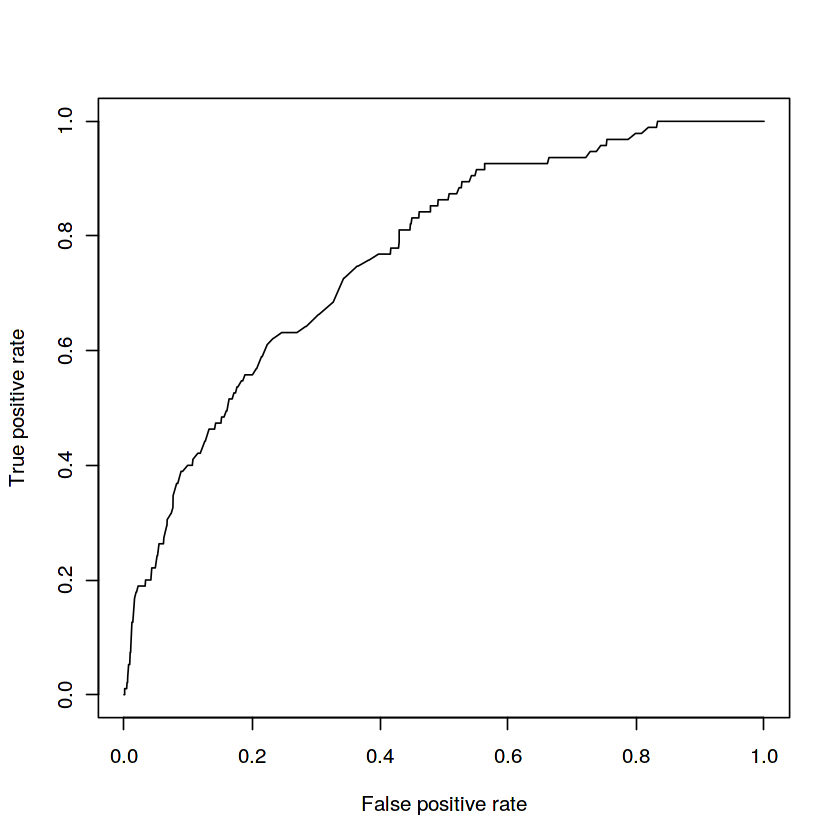

In [5]:
# prediction and performance functions are from package ROCR
plot_roc <- function(p, labels) {
  pred <- prediction(p, labels)
  perf <- performance(pred,"tpr","fpr")
  plot(perf, col="black")
}
plot_roc(y_pred, frisked_df$found_weapon)


### Train, validate, test

Selecting a model with the highest AUC on the dataset we train our model on is
not going to give us the "best" model that both perform and generalize well.
Keep in mind that we have two separate goals to achieve:

1. __Model selection__: estimating the performance of different models in order
to choose the best one

<a name="two_goals_back"></a>

2. __Model assessment__: having chosen a final model, estimating its prediction
error (generalization error) on new data<sup>[3](#two_goals)</sup>


One good way to achieve both goals is to divide our dataset into three parts:
_training set_, _validation set_, and _test set_.
We fit our model using the training set; then we use a validation set to
select a model that achieve the best performance (e.g., based on AUC).
<!-- estimate prediction performance (e.g., evaluate AUC) for model selection; -->
Finally, we use the test set to assess the generalization error of the model
that we end up selecting.
Note that the performance that we estimate on the validation set for our
selected model will likely be an overestimate of the model's true performance;
exactly because we happened to choose the model that achieved the highest
performance on the validation set.
Hence, we need the final step---performance evaluation on a test set---to get
an unbiased estimate of the model's generalization error.
<!--
Note that we may go back and forth between those stages, but generally we should
refrain from using the test set until we are set on the choice of final model.
If we repeatedly using the test set in the process of choosing our model, we are going to underestimate the true test (generalization) error.
-->

<a name="splits_back"></a>

One way to split our data into training, validation, and test set with
50%, 25%, and 25% of the data, respectively, we have<sup>[4](#splits)</sup>:

In [6]:
set.seed(123)

# shuffle the dataset first
shuffled <- frisked_df[sample(nrow(frisked_df)),]


# Your code here!
# we should first calculate the size of our training, validation, and test size
# and then use the slice function to slice the data into three pieces of corresponding
# sizes: train_df, valid_df, and test_df
# START solution

train_len <- round(0.5 * nrow(shuffled))
valid_len <- round(0.25 * nrow(shuffled))

train_df <- shuffled %>% slice(1:train_len)
valid_df <- shuffled %>% slice((train_len + 1):(train_len + valid_len))
test_df <- shuffled %>% slice((train_len + valid_len + 1):nrow(shuffled))

# END solution

Then we can fit our model on the training set

In [7]:
# Using formula
form <- formula(found_weapon ~ suspect_age + suspect_race + suspected_crime)
lr <- glm(form, data = train_df, family = binomial)
y_pred <- predict(lr, train_df, type="response")

# Training AUC
format(compute_auc(y_pred, train_df$found_weapon), digits=3)

[1] "0.771"


Next, we can estimate prediction performance on our validation set.
We see a significant performance drop in terms of AUC, suggesting that our
logistic regression model is overfiting the training data.

In [8]:
y_pred <- predict(lr, valid_df, type="response")

# Validation AUC
format(compute_auc(y_pred, valid_df$found_weapon), digits=3)

[1] "0.755"

Finally, we examine performance on the test set
(since we do not select our model here, the test set is rather trivial)

In [9]:
y_pred <- predict(lr, test_df, type="response")

# test AUC
format(compute_auc(y_pred, test_df$found_weapon), digits=3)

[1] "0.759"


### Cross validation

When evaluating a model's performance, sometimes we may not want to limit the
performance evaluation to a spcific subset of the data (e.g., the validation
set).
Then, we can use _k-fold cross validation_.
In a k-fold cross validation, we devide the data into $k$ (randomly shuffled)
subsets.
For each subset, we will use the remaining $k-1$ subsets as our training set,
and evaluate the model's performance on this subset. 
By averaging the performance over all $k$ subset, we are able to obtain a
performance estimation based on all the (training and validation) data we have.
Note that, when using cross validatoin, we would still like to hold out a test 
set for the same reason stated in the _train, validate, test_ subsection.

One combination of the two model selection paradigms is to separate the dataset
into training and test set, then conduct cross valiation within the training set
(so that we are creating many validation sets during cross validation); 
and then after selecting a final model, we evaluate its generalization error on
the held-out test set.


### Creating simple models

<a name="other_model_back"></a>
With these model evaluation frameworks, we can start conducting a model
selection processes to decide what variables we would like to include in our
logistic regression<sup>[5](#other_model)</sup>.
In order to fit the training set the best, one obvious idea is to use as many as
variables as possible, but that is going to increase the model complexity and
potentially lead to overfitting.
Additionally, too many coefficients for these variables also make it hard for us
to interpret the model.
We will now discuss how to create simpler models via _feature selection_ and
_regularization_.



## Feature Selection

<a name="feature_vs_variable_back"></a>
One way to create simple models is to limit the number of
features<sup>[6](#feature_vs_variable)</sup> while keep the functional form of the model 
intact.
We discussed 3 ways of doing so in class.

<a name="not_only_regression_back"></a>
The most straightfoward way to find out whether a regression models with fewer 
variables would perform well is to fit the regression with all possible subsets 
of features. 
This method is referred to as best subset regression<sup>[7](#not_only_regression)</sup>. 
However, with $k$ features, it requires fitting $2^k$ different regression
models, which is computationally expensive and inefficient.

Alternatively, a greedy search for the best subset called _forward stepwise
regression_ can be adopted. 
The idea is simple: we add one feature at time, choosing the single feature that
improves the performance most.
Specifically:

1. We start with only an intercept in the regression
2. We try adding each of the unselected features to our exisiting model,
   and calculate performance (e.g., AUC, accuracy, 
   [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion),
   [BIC](https://en.wikipedia.org/wiki/Bayesian_information_criterion)) 
3. Select the feature that achieves the highest performance and include that
   feature into our exisiting model
4. Repeat step 2 and 3 until all features are added to the model
5. Select the model that performs the best

Another similar approach is _backward stepwise regression_ where, instead of
starting with only the intercept and incrementally adding new features, we start
with the model including all features, and remove one feature at a time that
reduce the performance metric the least.

## Regularization

Another way to prevend overfitting by simplifying models is to "shrink" 
coefficients via regularization.
We discussed two types of regularization in class: $L^1$ regularization (lasso)
and $L^2$ regularization (ridge).
Regularizations are implemented by having the regression adopt different loss 
functions that essentially penalize big coefficients.

Regularizations are particularly helpful when many features are highly
correlated (see
[multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity)), in which 
case, the coefficients can be poorly determined and therefore result in high 
variance in our mdoel.


<a name="see_more_glmnet_back"></a>
In practice, we can use the `glmnet` package in `R` to implement lasso or
ridge<sup>[8](#see_more_glmnet)</sup>.
<a name="elastic_net_back"></a>
Setting parameter `alpha = 1` gives us lasso regression and setting `alpha = 0` 
gives us ridge regression<sup>[9](#elastic_net)</sup>.
The `lambda` parameter corresponds to the $\lambda$ term in the loss function 
introduced in class, indicating how heavily we would like to penalize large 
coefficients.
The larger $\lambda$ is, the smaller and/or sparser the coefficients are likely 
to be.

In [10]:
set.seed(123)

# Recall that we defined our model formula as form
print(form)

# Unlike lm(), we need to construct the design matrix and a vector of labesl
# when using glmnet()
x <- model.matrix(form, train_df)[,-1]
y <- train_df$found_weapon
lasso <- glmnet(x, y, alpha = 1, lambda = 5e-3, family = "binomial")
ridge <- glmnet(x, y, alpha = 0, lambda = 1e-1, family = "binomial")
x_valid <- model.matrix(form, valid_df)[,-1]
y_valid <- valid_df$found_weapon

# using our pre-trained unregularized logistic regression
y_pred_lr <- predict(lr, valid_df, type="response")
# L1 regularization, or lasso
y_pred_lasso <- predict(lasso, newx = x_valid, type = "response")
# L2 regularization, or ridge
y_pred_ridge <- predict(ridge, newx = x_valid, type = "response")

#comparing performance on validation set
paste("logistic AUC:", format(compute_auc(y_pred_lr, y_valid), digits=3))
paste("lasso AUC:", format(compute_auc(y_pred_lasso, y_valid), digits=3))
paste("ridge AUC:", format(compute_auc(y_pred_ridge, y_valid), digits=3))

found_weapon ~ suspect_age + suspect_race + suspected_crime


[1] "logistic AUC: 0.755"

[1] "lasso AUC: 0.765"

[1] "ridge AUC: 0.764"

If we compare the coefficients of lasso and ridge, we observe that dispite their similar AUCs, lasso produces sparser coefficients (i.e., many zero coefficients) while ridge on average gives smaller coefficient values.

In [11]:
# lasso coefficients
print(coef(lasso))

14 x 1 sparse Matrix of class "dgCMatrix"
                                                                s0
(Intercept)                                               -4.31493
suspect_age                                                0.00547
suspect_racehispanic                                       0.19957
suspect_racewhite                                          0.44103
suspected_crimecpw                                         1.40421
suspected_crimecriminal possesion of controlled substance  .      
suspected_crimecriminal possession of marihuana            0.57712
suspected_crimecriminal sale of controlled substance       .      
suspected_crimecriminal trespass                           .      
suspected_crimegrand larceny                               .      
suspected_crimegrand larceny auto                          0.48676
suspected_crimepetit larceny                               .      
suspected_crimerobbery                                     .      
suspected_crimeother

In [12]:
# ridge coefficients
print(coef(ridge))

14 x 1 sparse Matrix of class "dgCMatrix"
                                                                s0
(Intercept)                                               -3.53141
suspect_age                                                0.00443
suspect_racehispanic                                       0.09715
suspect_racewhite                                          0.18210
suspected_crimecpw                                         0.37691
suspected_crimecriminal possesion of controlled substance -0.27448
suspected_crimecriminal possession of marihuana            0.23346
suspected_crimecriminal sale of controlled substance      -0.26810
suspected_crimecriminal trespass                          -0.26035
suspected_crimegrand larceny                              -0.27563
suspected_crimegrand larceny auto                          0.09905
suspected_crimepetit larceny                              -0.27036
suspected_crimerobbery                                    -0.21641
suspected_crimeother

During this particular model training and selection process, the `lambda`
parameter is the one we will be tuning.
Ultimately, we wish to select the value of `lambda` that achieves best
performance on the validation set.

Now let's see what the best model we can find that yields the highest validation AUC:

In [13]:
# Your code here!
# Train a model named "selected_model" that yields the highest validation AUC
# START solution

selected_model <- glmnet(x, y, alpha = 0, lambda = 3.47, family = "binomial")
y_pred <- predict(selected_model, newx = x_valid, type = "response")
paste("Best AUC:", format(compute_auc(y_pred, y_valid), digits=3))

# END solution

[1] "Best AUC: 0.77"


After many rounds of testing different `lambda`s, it seems that ridge with 
`lambda = 0.1` performs the best.
So now let's take a look at it's generalization performance by checking the test
set:


In [14]:
x_test <- model.matrix(form, test_df)[,-1]
y_test <- test_df$found_weapon
y_test_pred_ridge <- predict(selected_model, newx = x_test, type = "response")
format(compute_auc(y_test_pred_ridge, y_test), digits=3)

[1] "0.751"

## (Optional) Advanced selection of `lambda`

<a name="nlambda_back"></a>

In the previous section, we compared regularized models with rather arbitrary
values of `lambda`.
In reality, we would fit models for multiple values of `lambda`s, and use our 
validation set to find the "best" of `lambda`.
The `glmnet` package actually implements an efficient method for fitting 
regularized models with many `lambda` values (also referred to the 
_regularization path_), as long as we specify the number of `lambda` values
we would like to try<sup>[10](#nlambda)</sup>.
As an exercise, we could repeat the previous section, but with 10 values of
`lambda` for both lasso and ridge regression:

In [15]:
# Create a list of models so we can keep track for later
models <- list(logistic = lr)

# First start with a unregularized logistic regression model
y_pred_lr <- predict(lr, valid_df, type="response")
perf_df <- tibble(
  model = "logistic",
  alpha = NA,
  lambda = 0,
  auc =  compute_auc(y_pred_lr, y_valid)
)
models$lasso <- glmnet(x, y, alpha = 1, nlambda = 10, family = "binomial")

# You can extract the (multible) values of lambda used for glmnet via $lambda
# here, we add the performance of each lambda value to perf_df
perf_df <- bind_rows(
  perf_df, 
  map_dfr(models$lasso$lambda, ~ tibble(  
    model = "lasso",  
    alpha = 1,  
    lambda = .x,  
    auc = compute_auc( 
      predict(models$lasso, x_valid, s = .x),
      y_valid
      ))))

# We can repeat the same for ridge models
models$ridge <- glmnet(x, y, alpha = 0, nlambda = 10, family = "binomial")
perf_df <- bind_rows(
  perf_df, 
  map_dfr(models$ridge$lambda, ~ tibble(  
    model = "ridge",
    alpha = 0,  
    lambda = .x,  
    auc = compute_auc( 
      predict(models$ridge, x_valid, s = .x),  
      y_valid
      ))))

# Then, we can sort perf_df by auc to find the "best" model
best_model_specs <- perf_df %>% 
  arrange(desc(auc)) %>% 
  slice(1)
best_model_specs

model,alpha,lambda,auc
<chr>,<dbl>,<dbl>,<dbl>
ridge,0,3.47,0.77


In [16]:
# We can evalute the performance of the "best" model on our test set
best_model <- models[[best_model_specs$model]]
pred_test <- predict(best_model, x_test, s = best_model_specs$lambda)

format(compute_auc(pred_test, y_test), digits=3)

[1] "0.751"

### Footnote:

<a name="auc_is_bad">1</a>. By "AUC" we often mean AUROC, as in this class. 
However, in general, a more precise acronym is AUROC, since technically AUC 
could be the area under any curve.
Indeed, "AUC" sometimes may refer to the "Area Under the precision-recall Curve". &nbsp;&nbsp; [\[go back\]](#auc_is_bad_back)

<a name="auc_below_50">2</a>. If you have a worse than random model (e.g., you intentionally set your prediction to be $1-p$ where $p$ is the prediction of model that performs well), the AUC can drop below 0.5. &nbsp;&nbsp; [\[go back\]](#auc_below_50_back)

<a name="two_goals">3</a>. From section "Model Assessment and Selection" in Trevor, Hastie,
Tibshirani Robert, and Friedman JH. "The elements of statistical learning: data
mining, inference, and prediction." (2009). &nbsp;&nbsp; [\[go back\]](#two_goals_back)

<a name="splits">4</a>. Note that there are many ways to split a given dataset into three
pieces. This decision, however, will largely depend on the size/context of the 
data, which is beyond the scope of our discussion. &nbsp;&nbsp; [\[go back\]](#splits_back)


<a name="other_model">5</a>. The process of model selection can involve both the selection of
variables (features) and their corresponding parameters and the selection of
different models (e.g., SVM, Gaussian processes, neural networks). 
In this discussion, we will focusing on selection of features and model
parameters. &nbsp;&nbsp; [\[go back\]](#other_model_back)

<a name="feature_vs_variable">6</a>. In this section, we use the word feature and variable
interchangeably.
They both refer to the covariates we include in our logistic regression model. &nbsp;&nbsp; [\[go back\]](#feature_vs_variable_back)

<a name="not_only_regression">7</a>. Although the feature selection methods we mention ended 
with "regression", they can easily be adapted for use with other statistical or
machine learning models. &nbsp;&nbsp; [\[go back\]](#not_only_regression_back)

<a name="see_more_glmnet">8</a>. As always, learn more about `glmnet` by typing `?glmnet` in
`R` &nbsp;&nbsp; [\[go back\]](#see_more_glmnet_back)

<a name="elastic_net">9</a>. Setting `alpha` to be somewhere between 0 and 1, on the other
hand, results in [elastic net
regularization](https://en.wikipedia.org/wiki/Elastic_net_regularization). &nbsp;&nbsp; [\[go back\]](#elastic_net_back)

<a name="nlambda">10</a>. Indeed, if you read the documentation for `glmnet` carefully, 
you'll find that manually specifying a single value value of `lambda` is
actually _discouraged_!
We just do that in this class to keep things a little (conceptually) simpler.
 &nbsp;&nbsp; [\[go back\]](#nlambda_back)

